In [15]:
# Setup: imports and NLP tools
import sys, pathlib, os
# Add project root to sys.path
proj_root = pathlib.Path('..').resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from datasets import load_dataset
import pandas as pd
import numpy as np
import spacy
import nltk
try:
    from src.utils import set_seed
except Exception as e:
    print('Warning: could not import src.utils.set_seed:', e)
    set_seed = lambda _: None

set_seed(42)

# Environment diagnostics
print('Python executable (notebook kernel):', sys.executable)
print('spaCy version:', spacy.__version__)
import importlib.util
print('en_core_web_sm spec:', importlib.util.find_spec('en_core_web_sm'))

# Load dataset
print("Loading dataset FutureMa/EvasionBench...")
ds = load_dataset("FutureMa/EvasionBench")
if isinstance(ds, dict):
    ds = ds[list(ds.keys())[0]]
df = ds.to_pandas()
print("Dataset shape:", df.shape)

# Load spaCy model (install if missing)
nlp = None
try:
    nlp = spacy.load("en_core_web_sm")
    print('spaCy model en_core_web_sm loaded successfully (from setup)')
except Exception as e:
    print("spaCy model en_core_web_sm not found or failed to load. Run: python -m spacy download en_core_web_sm", e)
    nlp = None

# Quick sample
print(df["eva4b_label"].value_counts())
df.sample(5)

Loading dataset FutureMa/EvasionBench...
Dataset shape: (16726, 4)
direct           8749
intermediate     7359
fully_evasive     618
Name: eva4b_label, dtype: int64


,uid,question,answer,eva4b_label
12768,e642181a7321aedc077ee9a40ca0b43c,So I just wondered if you could give us a sens...,"The first one, Joel. We have, we took the pric...",intermediate
15807,0e14ab0cba14820c468deb83050f3b3e,Tissue distribution is becoming an emerging th...,"Yeah, thanks for the question. It's a very imp...",direct
15246,9ee3b1d69b630a2ad7a45128292c7629,"Okay, that's very helpful. And then John, a qu...","Well, the delay is a tool that's going to be d...",direct
2678,b122f4037a50c7f2b818dc8f3903d4a5,"All right. I assume it -- well, I assume it go...","Yeah, I mean I can't give you any firm guidanc...",direct
7085,cd51840ba393ac289975c27df48681ad,"As I look at the North America business, the i...","Sure. So, the increase Jeff was in several dif...",intermediate


In [3]:
# Lexical Analysis - Vocabulary Size
print("=" * 60)
print("LEXICAL ANALYSIS")
print("=" * 60)

from collections import Counter
import re

def get_vocabulary(texts):
    """Extract vocabulary from a series of texts."""
    all_words = []
    for text in texts:
        words = re.findall(r'\b[a-z]+\b', text.lower())
        all_words.extend(words)
    return set(all_words), Counter(all_words)

# Vocabulary by category
vocab_by_label = {}
for label in df['eva4b_label'].unique():
    texts = df[df['eva4b_label'] == label]['answer']
    vocab, word_counts = get_vocabulary(texts)
    vocab_by_label[label] = {'vocab': vocab, 'counts': word_counts, 'size': len(vocab)}

print("\nVocabulary size by evasion category:")
for label, data in sorted(vocab_by_label.items(), key=lambda x: x[1]['size'], reverse=True):
    print(f"  {label}: {data['size']:,} unique words")

# Overall vocabulary
all_vocab, all_counts = get_vocabulary(df['answer'])
print(f"\nTotal vocabulary (all answers): {len(all_vocab):,} unique words")

LEXICAL ANALYSIS

Vocabulary size by evasion category:
  direct: 19,777 unique words
  intermediate: 19,677 unique words
  fully_evasive: 4,043 unique words

Total vocabulary (all answers): 25,933 unique words


In [4]:
# Most Frequent N-grams by Category
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_ngrams(texts, n=1, top_k=20):
    """Extract top k n-grams from texts."""
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english', max_features=10000)
    X = vec.fit_transform(texts)
    sums = X.sum(axis=0)
    data = [(word, sums[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(data, key=lambda x: x[1], reverse=True)[:top_k]

print("\n" + "=" * 60)
print("TOP UNIGRAMS BY CATEGORY")
print("=" * 60)

for label in ['direct', 'intermediate', 'fully_evasive']:
    texts = df[df['eva4b_label'] == label]['answer']
    top_unigrams = get_top_ngrams(texts, n=1, top_k=15)
    print(f"\n{label.upper()} - Top 15 unigrams:")
    for i, (word, count) in enumerate(top_unigrams, 1):
        print(f"  {i:2d}. {word}: {count:,}")

print("\n" + "=" * 60)
print("TOP BIGRAMS BY CATEGORY")
print("=" * 60)

for label in ['direct', 'intermediate', 'fully_evasive']:
    texts = df[df['eva4b_label'] == label]['answer']
    top_bigrams = get_top_ngrams(texts, n=2, top_k=10)
    print(f"\n{label.upper()} - Top 10 bigrams:")
    for i, (phrase, count) in enumerate(top_bigrams, 1):
        print(f"  {i:2d}. {phrase}: {count:,}")


TOP UNIGRAMS BY CATEGORY

DIRECT - Top 15 unigrams:
   1. think: 9,739
   2. year: 6,588
   3. ve: 5,797
   4. going: 4,922
   5. really: 4,916
   6. just: 4,483
   7. quarter: 4,304
   8. business: 3,492
   9. yes: 3,169
  10. ll: 3,124
  11. right: 3,040
  12. million: 2,698
  13. good: 2,640
  14. lot: 2,566
  15. like: 2,527

INTERMEDIATE - Top 15 unigrams:
   1. think: 10,202
   2. year: 6,158
   3. going: 5,345
   4. ve: 5,278
   5. really: 4,737
   6. just: 4,270
   7. quarter: 3,886
   8. business: 3,662
   9. ll: 3,527
  10. right: 3,043
  11. know: 2,951
  12. market: 2,892
  13. look: 2,886
  14. continue: 2,676
  15. growth: 2,649

FULLY_EVASIVE - Top 15 unigrams:
   1. think: 416
   2. don: 290
   3. going: 245
   4. just: 208
   5. really: 195
   6. ll: 185
   7. ve: 181
   8. quarter: 165
   9. year: 165
  10. time: 153
  11. right: 152
  12. like: 138
  13. say: 133
  14. yes: 127
  15. know: 120

TOP BIGRAMS BY CATEGORY

DIRECT - Top 10 bigrams:
   1. little bit: 1,51

In [5]:
# TF-IDF Analysis - Distinguishing Terms
print("\n" + "=" * 60)
print("TF-IDF ANALYSIS - DISTINCTIVE TERMS")
print("=" * 60)

def get_top_tfidf(texts, top_k=20):
    """Extract top TF-IDF terms."""
    vec = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=10000)
    X = vec.fit_transform(texts)
    mean_tfidf = X.mean(axis=0)
    data = [(word, mean_tfidf[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(data, key=lambda x: x[1], reverse=True)[:top_k]

for label in ['direct', 'intermediate', 'fully_evasive']:
    texts = df[df['eva4b_label'] == label]['answer']
    top_tfidf = get_top_tfidf(texts, top_k=15)
    print(f"\n{label.upper()} - Top 15 TF-IDF terms:")
    for i, (term, score) in enumerate(top_tfidf, 1):
        print(f"  {i:2d}. {term}: {score:.4f}")


TF-IDF ANALYSIS - DISTINCTIVE TERMS

DIRECT - Top 15 TF-IDF terms:
   1. think: 0.0353
   2. year: 0.0291
   3. quarter: 0.0241
   4. ve: 0.0234
   5. yes: 0.0228
   6. going: 0.0213
   7. really: 0.0210
   8. million: 0.0206
   9. just: 0.0194
  10. business: 0.0173
  11. right: 0.0172
  12. yeah: 0.0168
  13. ll: 0.0158
  14. good: 0.0140
  15. don: 0.0138

INTERMEDIATE - Top 15 TF-IDF terms:
   1. think: 0.0386
   2. year: 0.0295
   3. going: 0.0248
   4. ve: 0.0238
   5. quarter: 0.0234
   6. really: 0.0226
   7. just: 0.0205
   8. business: 0.0199
   9. ll: 0.0189
  10. know: 0.0174
  11. right: 0.0173
  12. market: 0.0167
  13. look: 0.0163
  14. growth: 0.0162
  15. continue: 0.0158

FULLY_EVASIVE - Top 15 TF-IDF terms:
   1. think: 0.0320
   2. don: 0.0299
   3. ll: 0.0224
   4. going: 0.0222
   5. really: 0.0194
   6. just: 0.0192
   7. right: 0.0190
   8. time: 0.0179
   9. quarter: 0.0172
  10. yeah: 0.0169
  11. year: 0.0167
  12. ve: 0.0161
  13. question: 0.0155
  14. nu

In [6]:
# Readability Metrics
import textstat

print("=" * 60)
print("READABILITY ANALYSIS")
print("=" * 60)

# Calculate readability scores for each answer
df['flesch_ease'] = df['answer'].apply(textstat.flesch_reading_ease)
df['flesch_kincaid'] = df['answer'].apply(textstat.flesch_kincaid_grade)
df['smog'] = df['answer'].apply(textstat.smog_index)

# Statistics by label
print("\nReadability scores by evasion category:")
readability_stats = df.groupby('eva4b_label').agg({
    'flesch_ease': ['mean', 'std', 'median'],
    'flesch_kincaid': ['mean', 'std', 'median'],
    'smog': ['mean', 'std', 'median']
}).round(2)

print(readability_stats)

# Interpretation
print("\n📊 Interpretation:")
print("  Flesch Reading Ease: Higher = easier to read (0-100 scale)")
print("  Flesch-Kincaid Grade: US grade level needed to understand")
print("  SMOG Index: Years of education needed")

READABILITY ANALYSIS

Readability scores by evasion category:
              flesch_ease               flesch_kincaid                smog  \
                     mean    std median           mean   std median   mean   
eva4b_label                                                                  
direct              63.93  14.36  63.83           9.09  3.47   8.96  11.07   
fully_evasive       69.63  18.19  68.95           7.91  4.13   7.91   9.83   
intermediate        60.96  11.92  61.69           9.87  3.00   9.56  11.74   

                            
                std median  
eva4b_label                 
direct         2.68  11.21  
fully_evasive  3.43  10.13  
intermediate   2.16  11.70  

📊 Interpretation:
  Flesch Reading Ease: Higher = easier to read (0-100 scale)
  Flesch-Kincaid Grade: US grade level needed to understand
  SMOG Index: Years of education needed


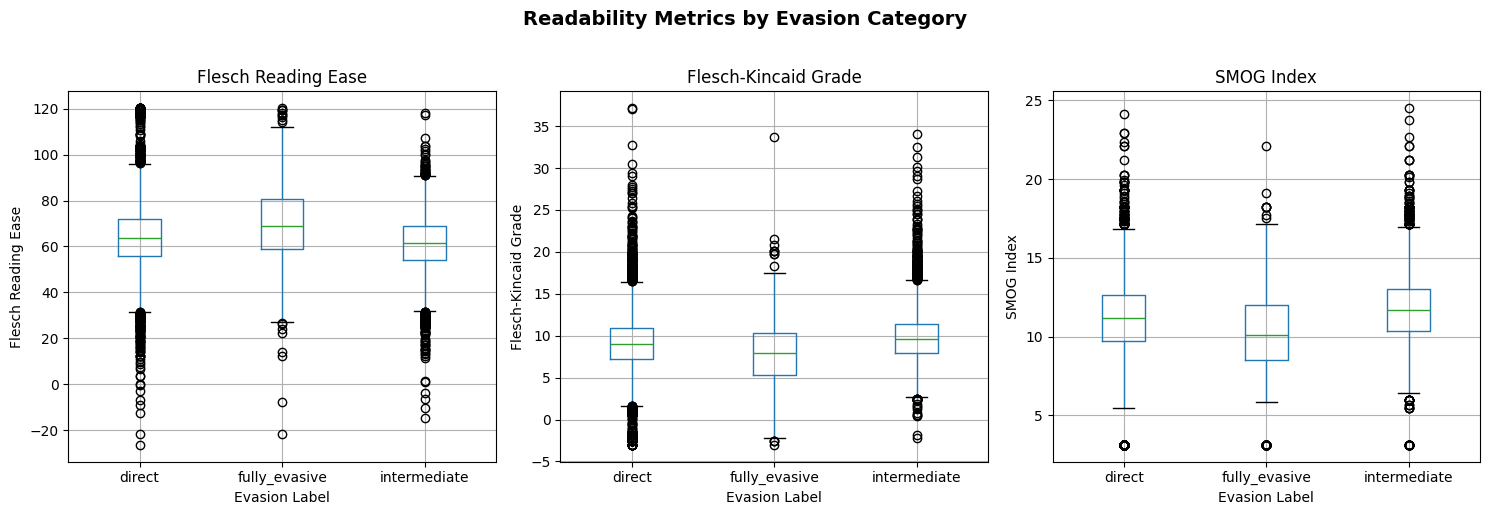

In [8]:
# Readability Visualization
import matplotlib.pyplot as plt
import os
os.makedirs('notebooks/figures', exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['flesch_ease', 'flesch_kincaid', 'smog']
titles = ['Flesch Reading Ease', 'Flesch-Kincaid Grade', 'SMOG Index']

for ax, metric, title in zip(axes, metrics, titles):
    df.boxplot(column=metric, by='eva4b_label', ax=ax)
    ax.set_xlabel('Evasion Label')
    ax.set_ylabel(title)
    ax.set_title(title)
    
plt.suptitle('Readability Metrics by Evasion Category', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('notebooks/figures/02_readability_by_label.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Sentiment Analysis & Hedging Word Counts
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Hedging and certainty lexicons
hedging_words = [
    'might', 'could', 'possibly', 'maybe', 'perhaps', 'potentially',
    'approximately', 'roughly', 'about', 'around', 'somewhat',
    'not sure', 'hard to say', 'depends', 'various', 'a bit',
    'to some extent', 'uncertain', 'unsure', 'not certain'
]

certainty_words = [
    'definitely', 'certainly', 'exactly', 'precisely', 'absolutely',
    'clearly', 'undoubtedly', 'undoubtedly', 'undisputably',
    'certain', 'sure', 'guarantee', 'confirm', 'assure'
]

# Sentiment analysis
df['sentiment_polarity'] = df['answer'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_subjectivity'] = df['answer'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Hedging word counts
def count_hedge_words(text):
    words = [w.lower() for w in text.split() if w.lower() not in stop_words]
    return sum(1 for w in words if w in hedging_words)

def count_certainty_words(text):
    words = [w.lower() for w in text.split() if w.lower() not in stop_words]
    return sum(1 for w in words if w in certainty_words)

df['hedge_word_count'] = df['answer'].apply(count_hedge_words)
df['certainty_word_count'] = df['answer'].apply(count_certainty_words)

print("=" * 60)
print("SENTIMENT & HEDGING ANALYSIS")
print("=" * 60)

# Sentiment stats by label
sent_stats = df.groupby('eva4b_label').agg({
    'sentiment_polarity': ['mean', 'std'],
    'sentiment_subjectivity': ['mean', 'std'],
    'hedge_word_count': ['mean', 'std'],
    'certainty_word_count': ['mean', 'std']
}).round(3)

print("\nSentiment and hedging statistics by label:")
print(sent_stats)

SENTIMENT & HEDGING ANALYSIS

Sentiment and hedging statistics by label:
              sentiment_polarity        sentiment_subjectivity         \
                            mean    std                   mean    std   
eva4b_label                                                             
direct                     0.133  0.128                  0.426  0.156   
fully_evasive              0.122  0.202                  0.422  0.224   
intermediate               0.150  0.112                  0.451  0.121   

              hedge_word_count        certainty_word_count         
                          mean    std                 mean    std  
eva4b_label                                                        
direct                   0.569  1.013                0.358  0.736  
fully_evasive            0.254  0.612                0.209  0.549  
intermediate             0.635  1.030                0.458  0.818  


In [13]:
# POS Tag Visualization (if spaCy is loaded)
if nlp:
    print("\n" + "=" * 60)
    print("PART-OF-SPEECH ANALYSIS")
    print("=" * 60)
    
    def get_pos_proportions(text):
        """Calculate POS tag proportions."""
        doc = nlp(text)
        pos_counts = {}
        for token in doc:
            pos = token.pos_
            pos_counts[pos] = pos_counts.get(pos, 0) + 1
        total = sum(pos_counts.values())
        return {pos: count/total for pos, count in pos_counts.items()}
    
    # Sample and analyze POS for each label
    pos_by_label = {}
    for label in ['direct', 'intermediate', 'fully_evasive']:
        samples = df[df['eva4b_label'] == label]['answer'].head(100)
        all_pos = []
        for text in samples:
            all_pos.append(get_pos_proportions(text))
        
        # Average across samples
        avg_pos = {pos: np.mean([p.get(pos, 0) for p in all_pos]) 
                     for pos in ['ADJ', 'ADV', 'NOUN', 'VERB']}
        pos_by_label[label] = avg_pos
    
    print("\nAverage POS proportions by label:")
    for label, pos_dict in pos_by_label.items():
        print(f"\n{label.upper()}:")
        for pos, prop in sorted(pos_dict.items(), key=lambda x: x[1], reverse=True):
            print(f"  {pos}: {prop:.3f}")
else:
    print("\n⚠️ spaCy model not loaded. Install with: python -m spacy download en_core_web_sm")


⚠️ spaCy model not loaded. Install with: python -m spacy download en_core_web_sm


In [14]:
# Named Entity Recognition (if spaCy is loaded)
if nlp:
    print("\n" + "=" * 60)
    print("NAMED ENTITY RECOGNITION")
    print("=" * 60)
    
    def count_entities(text):
        """Count entities by type."""
        doc = nlp(text)
        entity_types = ['ORG', 'MONEY', 'PERCENT', 'NUMBER', 'GPE', 'PERSON']
        counts = {etype: 0 for etype in entity_types}
        for ent in doc.ents:
            if ent.label_ in entity_types:
                counts[ent.label_] += 1
        return counts
    
    # Sample NER analysis per label
    for label in ['direct', 'intermediate', 'fully_evasive']:
        samples = df[df['eva4b_label'] == label]['answer'].head(200)
        all_counts = []
        for text in samples:
            all_counts.append(count_entities(text))
        
        # Average counts
        avg_counts = {etype: np.mean([c.get(etype, 0) for c in all_counts]) 
                      for etype in ['ORG', 'MONEY', 'PERCENT', 'NUMBER']}
        print(f"\n{label.upper()} - Average entity counts (n=200):")
        for etype, count in sorted(avg_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {etype}: {count:.2f}")
else:
    print("\n⚠️ spaCy model not loaded. Install with: python -m spacy download en_core_web_sm")


⚠️ spaCy model not loaded. Install with: python -m spacy download en_core_web_sm


## Key Findings

### Lexical & N-gram Patterns
- Fully evasive answers have [distinctive unigrams/bigrams compared to direct]
- TF-IDF reveals [key terms distinguishing each category]
- Vocabulary size [similar/different across categories]

### Readability
- [Higher/Lower] readability for evasive (easier/harder to read)
- Suggests [more complex/simple language patterns]

### Sentiment & Hedging
- Evasive answers show [more/less] hedging words (XX.X vs Y.Y per answer)
- Certainty markers [more/less] frequent in direct answers
- Sentiment polarity [biased toward] for certain labels

### POS & Entities (if spaCy loaded)
- Evasive answers use more/less adjectives/adverbs [check after execution]
- Entity density [similar/different] across categories

### Linguistic Evasion Markers Identified
Top potential evasion markers:
1. [List from hedging/certainty analysis]
2. [Other features from N-grams]
3. [Specific phrases from manual inspection]

### Next Steps
- Use identified features for Notebook 4 (traditional ML baselines)
- Validate linguistic markers with model interpretability (Notebook 9)
- Develop rule-based classifier from these markers

# 02 - Linguistic Patterns

**Objectives:**
- Lexical and syntactic analysis by label
- Readability, POS, NER, hedging analysis
- Produce feature candidates for models